## Latent Dirichlet Allocation (LDA) Modelling for diet related questions
We have scrapped weight and diet related questions from various Community Question Answering (CQA) websites. We aim to identify questions topics and ultimately group an unseen question to one of the topics. This would enable the clinician to provide a generic answer to a commo topic, simplifying the Q&A process. If the user finds that the questions has not been answered correctly, it will then be recorded for further clarification during their next clinic consultation

In [17]:
# !pip install wordcloud
# !pip install gensim
# !pip install spacy
# pip install joblib

## import all the required packages

In [3]:
import pandas as pd
import os
import gensim 
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
 



In [4]:
# Read data into questions
data = pd.read_csv('dataminer.csv', encoding = "ISO-8859-1")

# Print head
data.head()


,questions,link,unanswered,tag,Unnamed: 4,Unnamed: 5
0,I would like to seek some advice on keto diet....,https://www.quora.com/unanswered/I-would-like-...,True,Ketogenic Diet,4,0.894433
1,"I'm 178cm (5""10) and weigh 59-60kg. (Not sure ...",https://www.quora.com/Im-178cm-510-and-weigh-5...,False,Weights and Measures,19,0.894433
2,Can muscles in women help with weight loss?,https://www.quora.com/unanswered/Can-muscles-i...,True,Muscles,0,0.012501
3,How do I get the Ketovatru program weight loss...,https://www.quora.com/unanswered/How-do-I-get-...,True,Diet,0,0.010001
4,How is Warren Buffett and Bill Gates able to s...,https://www.quora.com/How-is-Warren-Buffett-an...,False,Diet Coke,11,0.940615


In [5]:
data.count()

questions     2226
link          2226
unanswered    2146
tag           2219
Unnamed: 4    2226
Unnamed: 5    2226
dtype: int64

#### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data and drop other metadata columns

In [6]:
# Remove the columns
data = data.drop(columns=['link', 'unanswered', 'tag'], axis=1)

# Print out the first rows of questions
data.head()

,questions,Unnamed: 4,Unnamed: 5
0,I would like to seek some advice on keto diet....,4,0.894433
1,"I'm 178cm (5""10) and weigh 59-60kg. (Not sure ...",19,0.894433
2,Can muscles in women help with weight loss?,0,0.012501
3,How do I get the Ketovatru program weight loss...,0,0.010001
4,How is Warren Buffett and Bill Gates able to s...,11,0.940615


#### Text Pre-Processing
We have use gen-sim simple preprocess util to 
(1) Tokenize the textual data.
(2) convert to list of lowercase tokens
(3) deacc = True removes punctuation


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data['questions']))

print(data_words)

[['would', 'like', 'to', 'seek', 'some', 'advice', 'on', 'keto', 'diet', 'is', 'this', 'diet', 'effective', 'is', 'it', 'worth', 'something', 'to', 'try', 'out'], ['cm', 'and', 'weigh', 'kg', 'not', 'sure', 'how', 'much', 'that', 'is', 'in', 'pounds', 'am', 'skinny', 'by', 'society', 'expectations'], ['can', 'muscles', 'in', 'women', 'help', 'with', 'weight', 'loss'], ['how', 'do', 'get', 'the', 'ketovatru', 'program', 'weight', 'loss', 'successfully', 'through', 'exercises'], ['how', 'is', 'warren', 'buffett', 'and', 'bill', 'gates', 'able', 'to', 'stay', 'healthy', 'even', 'though', 'they', 'eat', 'hamburgers', 'drink', 'milkshakes', 'coke', 'and', 'diet', 'coke'], ['slow', 'carb', 'diet', 'increases', 'heat', 'in', 'my', 'body', 'through', 'eggs', 'and', 'chickens', 'how', 'do', 'reduce', 'the', 'heat', 'but', 'maintain', 'the', 'diet'], ['how', 'do', 'gain', 'weight', 'after', 'recovering', 'from', 'an', 'accident'], ['can', 'acetazolamide', 'make', 'you', 'lose', 'weight'], ['is',

### Remove stopwords & known search terms

Remove stop words that appear in high frequency and is useless

Remove known key search terms used for data scrapping such as weight loss, diet,  lose weight

In [8]:
# Let's load up English corpus from NLTK package.
# stop_words = stopwords.words('english')
# stop_words.extend(['on', 'im'])
# print(stop_words)

def remove_stopwords(texts):
    data_words_filtered = []
    temp = []
    stop_words = stopwords.words('english')
    stop_words.extend(['im', 'ive', 'seems', 'could', 'cant', 'would', 'also', 'much', 've', 'get', 'weight', 'diet', 'loss', 'lose'])
#     print(stop_words)

    for sent in texts:
        temp = []
        for w in sent:
            if w not in stop_words:
                 temp.append(w)
        data_words_filtered.append(temp)
    return data_words_filtered

data_words_filtered = remove_stopwords(data_words)
# print(data_words_filtered)



### Lemmatization
Ref: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizerwithappropriatepostag

In [9]:
# Find out the correct POS tag for each word, map it to the right input character 
def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)



def lemmatization(texts):    
    lemmatizer = WordNetLemmatizer()   # 1. Init Lemmatizer
    
    lemma_data = []
    bag_of_words =[]
    for sentence in texts:
        temp = []
        for word in sentence:
            temp.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))  #Lemmatize Single Word with the appropriate POS tag
            bag_of_words.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
        lemma_data.append(temp)
    return lemma_data, bag_of_words

lemma_data_by_doc, lemma_data = lemmatization(data_words_filtered)


In [10]:
n = 0
lemma_dict = {}
for each_doc in lemma_data_by_doc:
    doc = " ".join(each_doc)
    lemma_dict[n] = doc
    n+=1
data['processed_questions'] = pd.DataFrame.from_dict(lemma_dict, orient='index')

#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

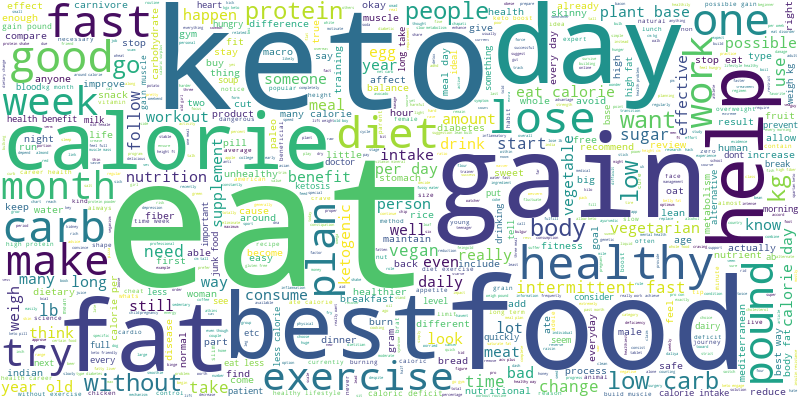

In [11]:
# Join the different processed titles together.
long_string = ','.join([word for word in lemma_data])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=800, height=400)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Creating Count Vectorizer
Count vectorizer counts the number of times a token shows up in the document and uses this value as its weight.[https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af]

The parameter min_df determines how CountVectorizer treats words that are not used frequently (minimum document frequency). If it is set to an integer, all words occurring less than that value will be dropped. If it is a fraction, all words that occur less than that fraction of the overall dataset will be dropped. The parameter max_df works in a similar manner.
https://www.datasciencecentral.com/profiles/blogs/python-scikit-learn-to-simplify-machine-learning-bag-of-words-to

In [12]:
# Initialise the count vectorizer with the English stop words
# count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer(min_df= 1, max_df = 0.9)

# Fit and transform the processed questions
data_vectorized = count_vectorizer.fit_transform(data['processed_questions'])


#### Prepare text for LDA analysis

Plot top 10 most common words

[('eat', 510.0), ('keto', 279.0), ('calorie', 259.0), ('day', 252.0), ('food', 208.0), ('gain', 183.0), ('fat', 153.0), ('fast', 151.0), ('healthy', 123.0), ('low', 118.0)]


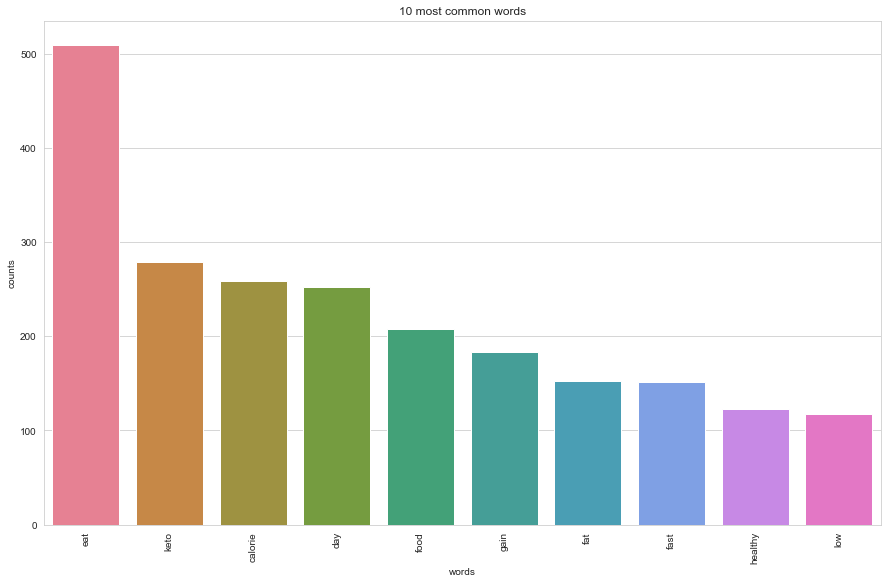

In [13]:
# Helper function
def plot_10_most_common_words(data_vectorized, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))

    for t in data_vectorized:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    print(count_dict)
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


# Visualise the 10 most common words
plot_10_most_common_words(data_vectorized, count_vectorizer)

### Check for sparsicity 
Ref: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn

Sparsicity is the percentage of non-zero datapoints in the document-word matrix

In [14]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.22994414649734626 %


In [15]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #" + str(topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 15
number_words = 2

# Create and fit the LDA model. 
# Random_state sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.

base_lda = LDA(n_components=number_topics, random_state=0)
base_lda.fit(data_vectorized)
base_lda_output = base_lda.transform(data_vectorized)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(base_lda, count_vectorizer, number_words)


Topics found via LDA:

Topic #1
keto work

Topic #2
keto eat

Topic #3
day calorie

Topic #4
kg ketogenic

Topic #5
pound food

Topic #6
low keto

Topic #7
keto follow

Topic #8
gain lb

Topic #9
best diet

Topic #10
eat protein

Topic #11
eat vegetable

Topic #12
year old

Topic #13
base plant

Topic #14
fast intermittent

Topic #15
eat gain


### Evaluating model performance
Ref: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn

Diagnosing model performance with perplexity and log-likelihood

Note: Perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words. This can be captured using topic coherence measure, an example of this is described in the gensim tutorial I mentioned earlier.

In [16]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", base_lda.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", base_lda.perplexity(data_vectorized))

# See model parameters
print(base_lda.get_params())

Log Likelihood:  -109368.41912556028
Perplexity:  1820.6101603733396
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 15, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


## Tunng hyper-parameters

### Method 1 - Using Log Likelihood Scores 
Ref: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn

In particular, given a corpus of documents D = {w1,w2,...,wM}, we wish to find parameters α and β that maximize the (marginal) log likelihood of the data https://ai.stanford.edu/~ang/papers/jair03-lda.pdf

In [32]:
# from sklearn.model_selection import GridSearchCV

# # Define Search Param
# search_params = {'n_components': [5, 8, 10, 15, 20, 25, 30],'learning_decay': [.5, .7, .9] }

# # Init the Model
# lda = LDA()

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)

# # Do the Grid Search
# model.fit(data_vectorized)

In [33]:
# score_5, score_7, score_9 = [], [], []
# for param_score in model.cv_results_['params']:
#     if param_score['learning_decay'] == 0.5:
#         index = model.cv_results_['params'].index(param_score)
#         score_5.append(round(model.cv_results_['mean_test_score'][index]))
# for param_score in model.cv_results_['params']:
#     if param_score['learning_decay'] == 0.7:
#         index = model.cv_results_['params'].index(param_score)
#         score_7.append(round(model.cv_results_['mean_test_score'][index]))
# for param_score in model.cv_results_['params']:
#     if param_score['learning_decay'] == 0.9:
#         index = model.cv_results_['params'].index(param_score)
#         score_9.append(round(model.cv_results_['mean_test_score'][index]))


In [34]:
# # Get Log Likelyhoods from Grid Search Output
# n_topics = [5, 8, 10, 15, 20, 25, 30]

# # Show graph
# plt.figure(figsize=(16, 8))
# plt.plot(n_topics, score_5, label='0.5')
# plt.plot(n_topics, score_7, label='0.7')
# plt.plot(n_topics, score_9, label='0.9')
# plt.title("Choosing Optimal LDA Model")
# plt.xlabel("Num Topics")
# plt.ylabel("Log Likelihood Scores")
# plt.legend(title='Learning decay', loc='best')
# plt.show()

Log Likelihood is not a good indicative of model performance as the metric is indirectly proportional to the number of topics. As such, we will attempt method 2

### Method 2 - Using coherence score
Ref: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [17]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(lemma_data_by_doc)
texts = lemma_data_by_doc
corpus = [id2word.doc2bow(text) for text in texts]
# print(corpus[:1])

In [18]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=0)

In [19]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model= lda_model, texts=lemma_data_by_doc, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.3021451629934798


In [ ]:
# supporting function
# def compute_coherence_values(corpus, dictionary, topic_param):
    
#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=topic_param, 
#                                            random_state=0)
    
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=lemma_data_by_doc, dictionary=dictionary, coherence='c_v')
    
#     return coherence_model_lda.get_coherence()

In [ ]:
# topic_param = [5,10,15,20,25,30,35,40]
# coherence_score = []
# for k in topic_param:
#     cv = compute_coherence_values(corpus=corpus, dictionary=id2word, topic_param=k)
#     coherence_score.append(cv)
    
# param_tuning_coherence = pd.DataFrame()
# param_tuning_coherence['coherence_score'] = coherence_score

In [ ]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

## Creating Document-Topic Matrix

In [20]:
# # # column names
topicnames = ["Topic" + str(i) for i in range(1, base_lda.n_components+1)]

# # # index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# # # Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(base_lda_output, 2), columns=topicnames, index=docnames)

# # Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)+1
df_document_topic['dominant_topic'] = dominant_topic

# # Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

df_document_topic



,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,dominant_topic
Doc0,0.01,0.90,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2
Doc1,0.01,0.01,0.01,0.39,0.01,0.01,0.51,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,7
Doc2,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.77,0.02,0.02,0.02,12
Doc3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.41,0.01,0.01,0.01,0.41,0.01,0.01,9
Doc4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc2221,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.69,15
Doc2222,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.69,0.02,0.02,0.02,12
Doc2223,0.01,0.01,0.01,0.01,0.01,0.81,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,6
Doc2224,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.41,0.42,0.01,0.01,0.01,0.01,0.01,10


In [21]:
# output results to csv
data['dominant_topic'] = dominant_topic
data.to_csv("model_output6.csv")

In [22]:
data[['processed_questions', 'dominant_topic']].groupby('dominant_topic').count().rename(columns={"processed_questions": "No. of docs"})


,No. of docs
dominant_topic,
1,122
2,145
3,261
4,129
5,122
6,171
7,90
8,157
9,165


Text(0, 0.5, 'Frequency')

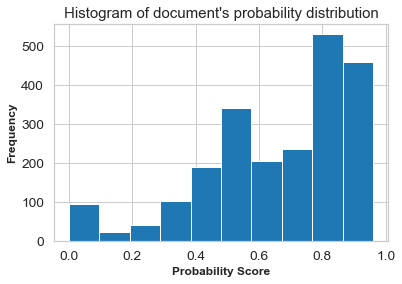

In [23]:
# histogram

hist_data = df_document_topic.iloc[: , 0:-2].max(axis=1)
hist = hist_data.hist()

 # Remove title
hist.set_title("Histogram of document's probability distribution")

# Set x-axis label
hist.set_xlabel("Probability Score", weight='bold', size=12)

# Set y-axis label
hist.set_ylabel("Frequency", weight='bold', size=12)

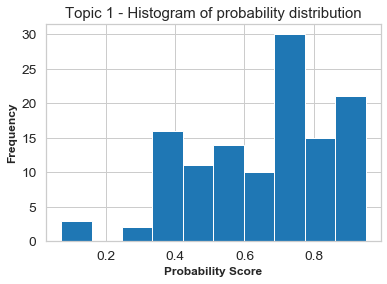

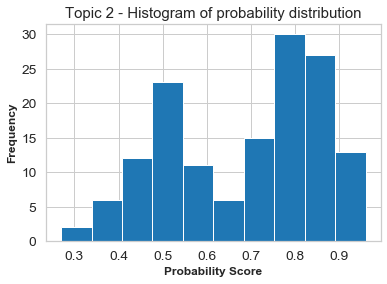

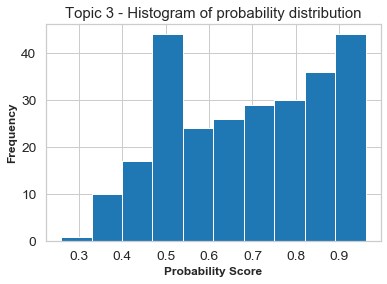

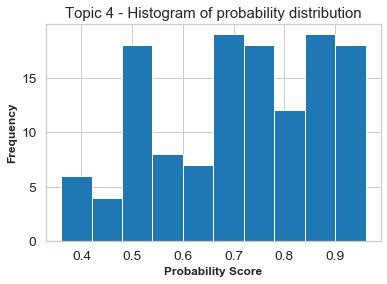

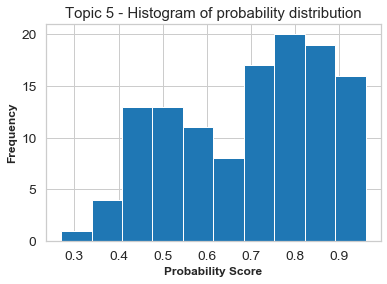

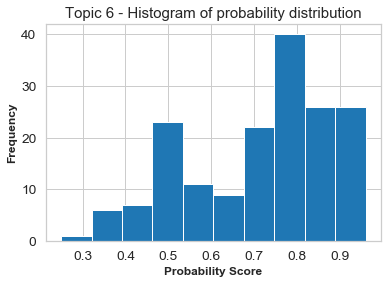

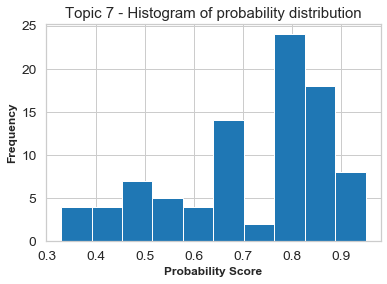

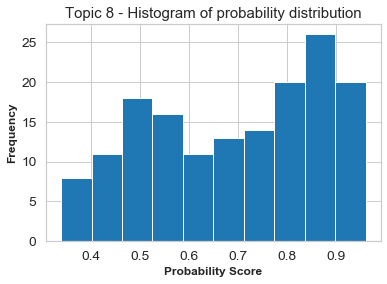

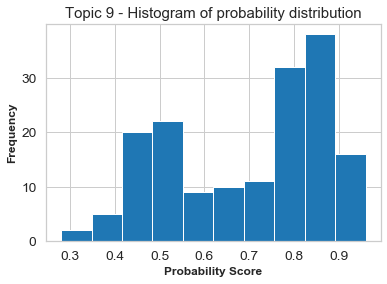

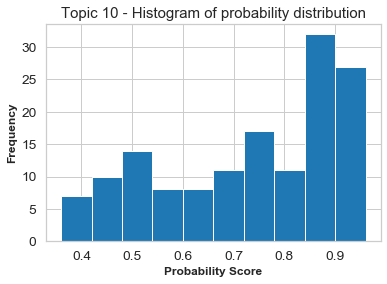

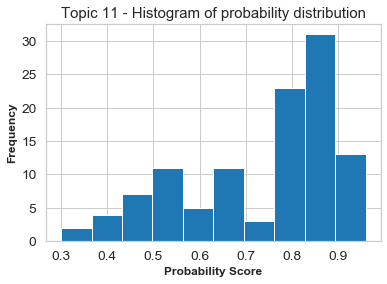

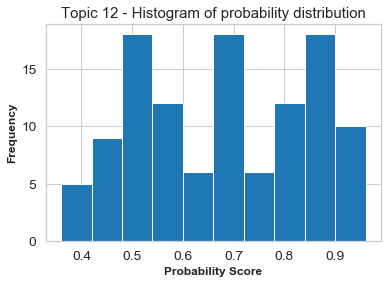

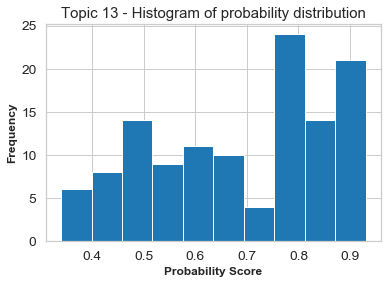

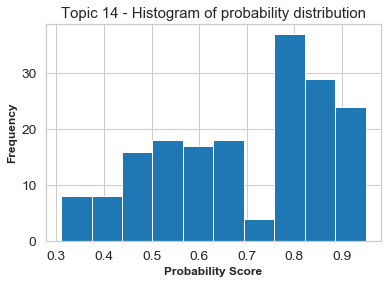

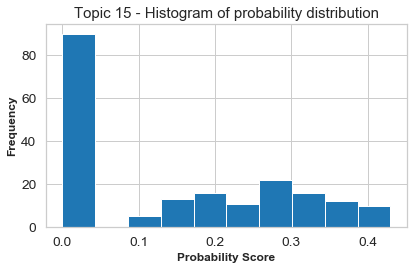

In [24]:
i=0
for n in range(1,16):
    each_top = df_document_topic.loc[df_document_topic['dominant_topic'] == n]

    fig = plt.figure()
    hist = fig.add_subplot(1,1,i+1)
    # histogram
    hist_data = each_top.iloc[: , 0:-2].max(axis=1)
    hist = hist_data.hist()

     # Remove title
    hist.set_title("Topic " + str(n) + " - Histogram of probability distribution")

    # Set x-axis label
    hist.set_xlabel("Probability Score", weight='bold', size=12)

    # Set y-axis label
    hist.set_ylabel("Frequency", weight='bold', size=12)
    
fig.tight_layout()  # Improves appearance a bit.
plt.show()



### Construct weight matrix for all keywords in each topic

In [25]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(base_lda.components_)

# Assign Column and Index
df_topic_keywords.columns = count_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ab,abandon,abide,abiity,able,abnegation,absolute,absorb,absorbed,abundant,...,yohimbe,yolk,young,youngster,youre,youtube,yr,zero,zigzag,zone
Topic1,1.066667,0.066667,0.066667,0.066667,1.618203,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic2,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.074067,0.066667,0.066667,0.066667,0.066667,1.066667
Topic3,0.066667,0.066667,1.066667,1.066667,2.817292,0.066667,0.066667,1.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic4,2.428245,0.066667,0.066667,0.066667,1.066666,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,2.066667,0.066667,1.066667,0.066668,0.066667,0.066667,0.066667,0.066667
Topic5,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,1.066667,0.066667,...,0.066667,0.066667,1.118752,0.066667,0.066667,0.066667,0.066667,3.066667,0.066667,0.066667


### Get Top n Keywords for each topic

In [26]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vectorizer, lda_model=base_lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=base_lda, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(1, df_topic_keywords.shape[1]+1)]
df_topic_keywords.index = ['Topic '+str(i) for i in range(1, df_topic_keywords.shape[0]+1)]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,keto,work,boost,free,important,long,safe,term,best,really
Topic 2,keto,eat,supplement,healthy,change,allow,lifestyle,use,work,like
Topic 3,day,calorie,eat,week,one,meal,per,fast,many,less
Topic 4,kg,ketogenic,month,way,cm,best,eat,body,possible,gain
Topic 5,pound,food,many,one,take,eat,gain,calorie,need,someone
Topic 6,low,keto,carb,eat,food,carbs,buy,sugar,possible,start
Topic 7,keto,follow,plan,easy,indian,food,work,kg,help,healthy
Topic 8,gain,lb,lose,start,weigh,food,pound,go,healthy,calorie
Topic 9,best,diet,fat,high,exercise,low,carb,feel,calorie,make
Topic 10,eat,protein,vegetarian,day,vegan,health,lose,drink,pound,enough


## Topic Visualization

In [27]:
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(base_lda, data_vectorized, count_vectorizer, sort_topics=False)
panel

pyLDAvis.save_html(panel, 'index_lda.html')

C:\Users\Xuesi\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### t-SNE visuals

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization


In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Array of topic weights 
arr = df_document_topic.iloc[:, :-1].values
# Dominant topic number in each doc
topic_num = df_document_topic["dominant_topic"].values

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])  # more colors: 'mcolors.XKCD_COLORS'
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(base_lda.n_components), 
              plot_width=900, plot_height=700)

plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

In [ ]:
# DEPLOYED VERSION 

def predict_topic(test_data):
    
    # data pre-processing
    test_words = list(sent_to_words([test_data]))
    test_words = remove_stopwords(test_words)
    test_lemma_by_doc, lemma_data = lemmatization(test_words)
    
    n = 0
    test_dict = {}
    for each_doc in test_lemma_by_doc:
        doc = " ".join(each_doc)
        test_dict[n] = doc
        n+=1
    test_df = pd.DataFrame.from_dict(test_dict, orient='index')
    
    test_vectorized = count_vectorizer.transform(test_df[0])
    topic_probability_scores = base_lda.transform(test_vectorized)
#     topic_keywords = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    topic = np.argmax(topic_probability_scores)
#     return topic, topic_keywords, topic_probability_scores
    return topic,  topic_probability_scores

# Predict the topic
test_data = "how to lose weight?"
# topic, topic_keywords, topic_probability_scores = predict_topic(test_data)
topic,  topic_probability_scores = predict_topic(test_data)
print("Test data is classified as Topic", topic+1)
# print("The keywords under this topic are:", topic_keywords)
print("Probability score:", topic_probability_scores)


In [ ]:
# IF YOU WANT TO PRINT OUT THE TOPIC KEYWORDS FROM THE DF_TOPIC_KEYWORDS

def predict_topic(test_data):
    
    # data pre-processing
    test_words = list(sent_to_words([test_data]))
    test_words = remove_stopwords(test_words)
    test_lemma_by_doc, lemma_data = lemmatization(test_words)
    
    n = 0
    test_dict = {}
    for each_doc in test_lemma_by_doc:
        doc = " ".join(each_doc)
        test_dict[n] = doc
        n+=1
    test_df = pd.DataFrame.from_dict(test_dict, orient='index')
    
    test_vectorized = count_vectorizer.transform(test_df[0])
    topic_probability_scores = base_lda.transform(test_vectorized)
    topic_keywords = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    topic = np.argmax(topic_probability_scores)
    return topic, topic_keywords, topic_probability_scores

# Predict the topic
# test_data = input("What is your question?")
for each in test_data:
# test_data = "Is KGX Keto a scam or not??"
    topic, topic_keywords, topic_probability_scores = predict_topic(test_data)
    print("Test data is classified as Topic", topic)
    print("The keywords under this topic are:", topic_keywords)
    print("Probability score:", topic_probability_scores)


In [ ]:
test_data = ["Is KGX Keto a scam or not?",
"What are the benefits of Electro Keto?",
"What are the wellness qualities in keto?",
"Does it matter what you eat if you take a multivitamin each day?", 
"Can we use keto pills while doing keto diet?",
"Who are the best weight loss experts in Mumbai?",
"Where can I get a customer keto-diet for free?", 
"What is the best dietitian and weight loss consultation near Kasba?", 
"How viable is KGX Keto?", 
"What is the ketogenic diet? How does it work?", 
"Does Wellness Qualities Keto really work?", 
"What is KGX Keto?"] 

### Deploying Model
Ref: https://towardsdatascience.com/deploy-your-data-science-model-7b81eea6c98

In [ ]:
from sklearn.externals import joblib
filename = "LDAmodel.sav"
joblib.dump(base_lda, filename)

In [ ]:
from sklearn.externals import joblib
filename = "vectorizer.sav"
joblib.dump(count_vectorizer, filename)

In [ ]:
model = joblib.load("LDAmodel.sav")
count_vectorizer = joblib.load("vectorizer.sav")

In [ ]:
def predict_topic(test_data):
    
    # data pre-processing
    test_words = list(sent_to_words([test_data]))
    test_words = remove_stopwords(test_words)
    test_lemma_by_doc, lemma_data = lemmatization(test_words)
    
    n = 0
    test_dict = {}
    for each_doc in test_lemma_by_doc:
        doc = " ".join(each_doc)
        test_dict[n] = doc
        n+=1
    test_df = pd.DataFrame.from_dict(test_dict, orient='index')
    
    test_vectorized = count_vectorizer.transform(test_df[0])
    topic_probability_scores = model.transform(test_vectorized)
    topic_keywords = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    topic = np.argmax(topic_probability_scores)
    return topic, topic_keywords, topic_probability_scores


# Predict the topic
# test_data = input("What is your question?")
test_data = "how to get started on keto?"
topic, topic_keywords, topic_probability_scores = predict_topic(test_data)
print("Test data is classified as Topic", topic)
print("The keywords under this topic are:", topic_keywords)
print("Probability score:", topic_probability_scores)

### Rough notes

In [ ]:
# # Construct the k-means clusters
# from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
# from sklearn.cluster import KMeans
# clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# # Build the Singular Value Decomposition(SVD) model
# svd_model = TruncatedSVD(n_components=2)  # 2 components
# lda_output_svd = svd_model.fit_transform(lda_output)

# # X and Y axes of the plot using SVD decomposition
# x = lda_output_svd[:, 0]
# y = lda_output_svd[:, 1]

# # Weights for the 15 columns of lda_output, for each component
# print("Component's weights: \n", np.round(svd_model.components_, 2))

# # Percentage of total information in 'lda_output' explained by the two components
# print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))


# # Plot
# plt.figure(figsize=(12, 12))
# plt.scatter(x, y, c=clusters)
# plt.xlabel('Component 2')
# plt.xlabel('Component 1')
# plt.title("Segregation of Topic Clusters", )

scikit learning:
-list https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
- explanation https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

plexity based: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4597325/
https://stackoverflow.com/questions/52986253/scoring-strategy-of-sklearn-model-selection-gridsearchcv-for-latentdirichletallo

likelihood: https://stats.stackexchange.com/questions/198078/interpretation-of-the-log-likelihood-in-clustering-techniques (proportion to num_topics)

clustering metric - eucleadean distance

clustering metric - sum of squared error within clusters

gridsearch (not that good for clustering)
-https://github.com/scikit-learn/scikit-learn/issues/13872
-https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit

R package:
https://cran.r-project.org/web/packages/ldatuning/vignettes/topics.html

coherence score & cross-fold(whati've done) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4597325/

no true ans: https://www.quora.com/Latent-Dirichlet-Allocation-LDA-What-is-the-best-way-to-determine-k-number-of-topics-in-topic-modeling

In [ ]:
# from sklearn.cluster import KMeans

# sse = pd.Series(range(30),index = range(1,31))
# for i in range(1,30):
#     clusters = KMeans(n_clusters=i, random_state=100).fit(base_lda_output)
#     sse[i] = clusters.inertia_
# print(sse)


In [ ]:
# plt.plot(sse.index, sse, linewidth=2.0)

In [ ]:
# from sklearn.externals import joblib
# filename = "model.sav"
# joblib.dump(base_lda, filename)

In [ ]:
# def predict_topic(test_data):
    
#     # data pre-processing
#     test_words = list(sent_to_words([test_data]))
#     test_words = remove_stopwords(test_words)
#     test_lemma_by_doc, lemma_data = lemmatization(test_words)
    
#     n = 0
#     test_dict = {}
#     for each_doc in test_lemma_by_doc:
#         doc = " ".join(each_doc)
#         test_dict[n] = doc
#         n+=1
#     test_df = pd.DataFrame.from_dict(test_dict, orient='index')
    
#     test_vectorized = count_vectorizer.transform(test_df[0])
#     topic_probability_scores = model.transform(test_vectorized)
#     topic_keywords = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     topic = np.argmax(topic_probability_scores)
#     return topic, topic_keywords, topic_probability_scores


# # Predict the topic
# test_data = input("What question do you have?")
# topic, topic_keywords, topic_probability_scores = predict_topic(test_data)
# print("Test data is classified as Topic", topic)
# print("The keywords under this topic are:", topic_keywords)
# print("Probability score:", topic_probability_scores)

In [ ]:
# response_df = pd.read_csv('response.csv', encoding = "ISO-8859-1")

In [ ]:
# r = response_df.loc[0, "response"]
# print(r)